In [1]:
%matplotlib inline

In [2]:
# Required modules

import os
import re
import warnings
warnings.filterwarnings('ignore')
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

In [3]:
# Reading data

data_path = "data"
csv_paths = glob(os.path.join(data_path, "*.csv"))
raw_data = {cp.rsplit('Data Analyst Assignment Round - ', 1)[-1].rsplit('.csv')[0]: pd.read_csv(cp) for cp in csv_paths}

In [4]:
# Cleaning to get age

date_re = r'[1-2]\d{3}'
age_re = r'\d+'

def get_age(ts, res):
    match = re.search(date_re, res)
    if match is not None:
        return int(re.search(date_re, ts).group(0)) - int(match.group(0))
    
    match = re.search(age_re, res)
    if match is not None:
        return int(match.group(0))
    
    return None

In [5]:
# Data Cleaning

data = {}

for k, df in raw_data.items():
    if "Module" in k:
        df = df.sort_values('Date Completed (UTC)')
        data[k] = df.drop_duplicates('Student ID', keep='first')
    else:
        data[k] = df
    data[k] = data[k].set_index('Student ID')
    
score = pd.DataFrame()
score['Student ID'] = data['Demographic Data'].index
score = score.set_index('Student ID')
score['age'] = data['Demographic Data'][['Date Completed', 'Response']].apply(lambda row: get_age(row[0], row[1]), axis=1)
score['education'] = data['Demographic Data']['Response.4']
    
for i in range(1, 4):
    # print(len(data[f'Module {i} PreTest']), len(data[f'Module {i} PostTest']))
    idx = data[f'Module {i} PreTest'].index.intersection(data[f'Module {i} PostTest'].index)
    data[f'Module {i} PreTest'] = data[f'Module {i} PreTest'].loc[idx]
    data[f'Module {i} PostTest'] = data[f'Module {i} PostTest'].loc[idx]
    score[f'Module {i} PreTest'] = data[f'Module {i} PreTest']['% Score']
    score[f'Module {i} PostTest'] = data[f'Module {i} PostTest']['% Score']

## Overall impact of each module
### Visualising PreTest and PostTest score distributions

A right shifted PostTest score distribution (compared to PreTest score distribution) would hint a postive impact of the module.

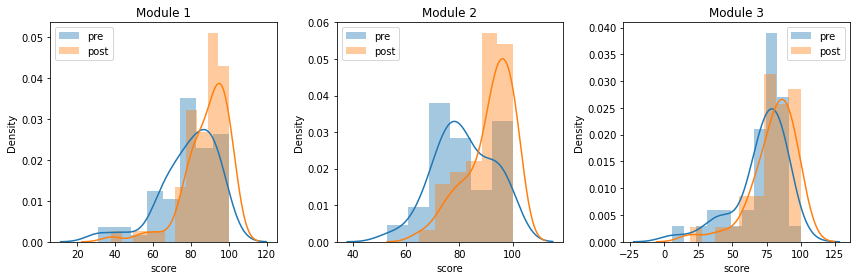

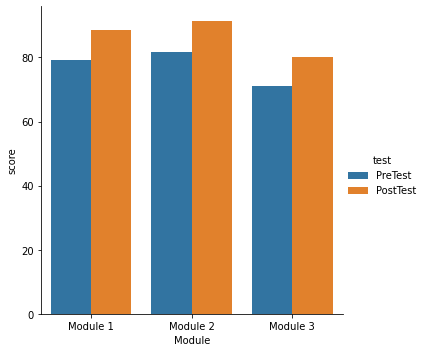

In [6]:
f, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(1, 4):
    sns.distplot(score[f'Module {i} PreTest'], label='pre', ax=axes[i-1])
    sns.distplot(score[f'Module {i} PostTest'], label='post', ax=axes[i-1])
    axes[i-1].legend()
    axes[i-1].set_xlabel('score')
    axes[i-1].title.set_text(f"Module {i}")
plt.tight_layout()
plt.show()
    
comp_table = pd.DataFrame()
comp_table['Module'] = [f'Module {i}' for i in range(1, 4)]
comp_table['PreTest'] = score[[f'Module {i} PreTest' for i in range(1, 4)]].mean().values
comp_table['PostTest'] = score[[f'Module {i} PostTest' for i in range(1, 4)]].mean().values
sns.catplot(data=pd.melt(comp_table, id_vars='Module', var_name='test'), x='Module', y='value', hue='test', kind='bar')
plt.ylabel('score')
plt.show()

The above plots show a hint of positive impact. To quantify it, we can define it as the change in score.

i.e., **impact = PostTest % Score - PreTest % Score**

In following cell we visualize the distribution of impact.

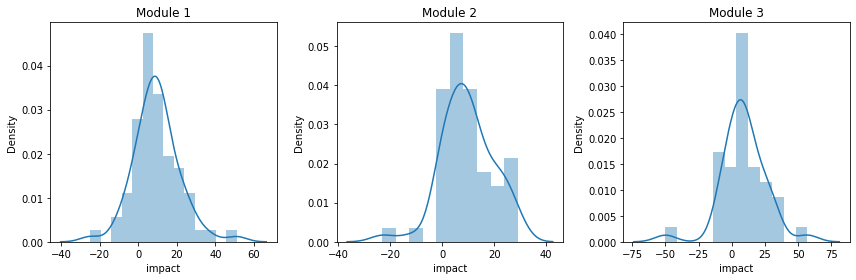

       Module 1 impact  Module 2 impact  Module 3 impact
count            66.00            54.00            39.00
mean              9.44             9.65             8.95
std              11.83            10.03            16.64
min             -25.00           -23.00           -50.00
25%               1.25             6.00             0.00
50%               7.00             8.00             7.00
75%              13.00            16.50            15.50
max              51.00            29.00            57.00


In [7]:
f, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(1, 4):
    score[f'Module {i} impact'] = score[f'Module {i} PostTest'] - score[f'Module {i} PreTest']
    sns.distplot(score[f'Module {i} impact'], ax=axes[i-1])
    axes[i-1].set_xlabel('impact')
    axes[i-1].title.set_text(f"Module {i}")
plt.tight_layout()
plt.show()
    
print(score[[c for c in score.columns if 'impact' in c]].describe().round(2))

### Hypothesis Testing

We will use Hypothesis Testing to check if the impact we saw above is by chance or is caused by the module. As central limit theorem states, the distribution of sample means approximates a normal distribution as the sample size gets larger. Therefore we will assume a normal distribution for average impact of a module.

**Null Hypothesis:** Module has no impact i.e., average impact (say m) follows distribution with mean = 0<br>
**Alternate Hypothesis:** mean of m > 0<br>
**Significance level:** 0.05 (Most commonly used)<br>
**Test statistic:** observed value of m = observed average impact<br>
**p-value:** Assuming null hypothesis is true, probability of obtaining m greater than or equal to observed value i.e., P(m >= observed value of m)

*Note*: Standard deviation (std) of distribution of m (under null hypothesis) can be approximated as std(sample)/sqrt(count).

In [8]:
alpha = 0.05

for i in range(1, 4):
    print(f"\nModule {i}:")
    mean = 0
    stddev = score[f'Module {i} impact'].std()/np.sqrt(score[f'Module {i} impact'].count())
    p_val = 1-stats.norm.cdf(score[f'Module {i} impact'].mean(), mean, stddev)
    print(f"p-value = {p_val}", end='')
    if p_val < alpha:
        print(f" < alpha => we reject null hypothesis. i.e., Module {i} has +ve impact")
        mean_impact_lb = np.round(score[f'Module {i} impact'].mean() - 2*stddev,2)
        mean_impact_ub = np.round(score[f'Module {i} impact'].mean() + 2*stddev, 2)
        print(f"With 95% confidence average impact of Module {i} lies in ({mean_impact_lb}, {mean_impact_ub})")
    else:
        print(f">= alpha => we don't have enough evidence to reject null hypothesis. i.e., impact could be by chance")


Module 1:
p-value = 4.511269136031615e-11 < alpha => we reject null hypothesis. i.e., Module 1 has +ve impact
With 95% confidence average impact of Module 1 lies in (6.53, 12.35)

Module 2:
p-value = 7.762679388179095e-13 < alpha => we reject null hypothesis. i.e., Module 2 has +ve impact
With 95% confidence average impact of Module 2 lies in (6.92, 12.38)

Module 3:
p-value = 0.0003919154342721942 < alpha => we reject null hypothesis. i.e., Module 3 has +ve impact
With 95% confidence average impact of Module 3 lies in (3.62, 14.28)


Another way to get more insights about this impact is to see how much potential improvement a module was able to realise. For this, we can look at the average impact relative to average potential impact. Let's call it normalised impact.

i.e., normalised impact = (average PostTest score - average PreTest score)/(100 - average PreTest score)

In [9]:
for i in range(1, 4):
    print(f"normalised impact for Module {i}: {round((score[f'Module {i} PostTest'].mean() - score[f'Module {i} PreTest'].mean())/(100 - score[f'Module {i} PreTest'].mean())*100, 2)}%")

normalised impact for Module 1: 45.05%
normalised impact for Module 2: 52.73%
normalised impact for Module 3: 30.97%


## Age-wise impact

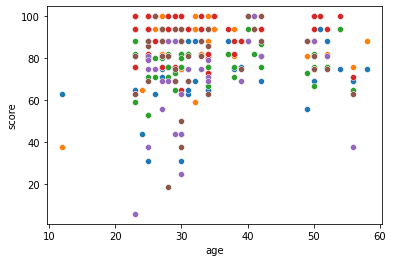

In [10]:
# Visualising age-wise score data to identify relevant age groups

score_temp = score.dropna(subset=['age'])

for i in range(1, 4):
    sns.scatterplot(x=score_temp['age'], y=score_temp[f'Module {i} PreTest'])
    sns.scatterplot(x=score_temp['age'], y=score_temp[f'Module {i} PostTest'])

plt.ylabel('score')
plt.show()

score_temp = score_temp[score_temp['age'] > 20]

From above plot, we can split the data into 4 age groups: <20, 20-32, 33-45, 45+. Since there's only 1 point in <20 age group, we consider it as an outlier and drop it from further analysis. Next we look at average impact in these age groups.

In [11]:
print(score_temp[[f'Module {i} impact' for i in range(1, 4)]].groupby(pd.cut(score_temp['age'], [20, 32, 45, 60])).mean().round(2).T, '\n')
print(score_temp[[f'Module {i} PreTest' for i in range(1, 4)]].groupby(pd.cut(score_temp['age'], [20, 32, 45, 60])).mean().round(2).T, '\n')

age              (20, 32]  (32, 45]  (45, 60]
Module 1 impact     11.24      7.28     10.00
Module 2 impact     10.33      6.81     12.75
Module 3 impact     11.17      7.27      2.40 

age               (20, 32]  (32, 45]  (45, 60]
Module 1 PreTest     76.97     84.56     78.56
Module 2 PreTest     81.43     83.50     79.12
Module 3 PreTest     65.83     80.82     74.00 



From 1st table, we see 2 observations:
1. Impact on age group 32-45 is comparatively lesser than other.
2. Module 3 did not have much impact on 45+ age group

But as we can see from 2nd table, PreTest scores for age group 32-45 were already higher and therefore the potential to improve was lower. To take this into account, we can look at normalised impact as defined above.

age              (20, 32]  (32, 45]  (45, 60]
Module 1 impact     48.80     47.12     46.63
Module 2 impact     55.66     41.29     61.08
Module 3 impact     32.70     37.91      9.23


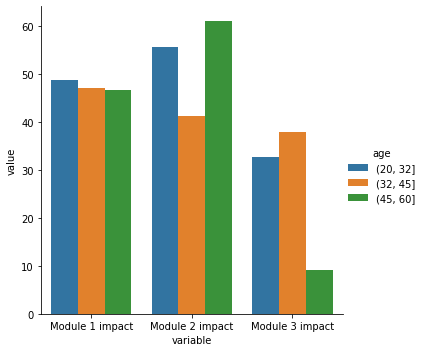

In [12]:
age_wise_impact = round(100*score_temp[[f'Module {i} impact' for i in range(1, 4)]].groupby(pd.cut(score_temp['age'], [20, 32, 45, 60])).mean()/
      (100-score_temp[[f'Module {i} PreTest' for i in range(1, 4)]].groupby(pd.cut(score_temp['age'], [20, 32, 45, 60])).mean().values), 2)

print(age_wise_impact.T)
age_wise_impact['age'] = age_wise_impact.index
sns.catplot(data=pd.melt(age_wise_impact, id_vars='age'), kind='bar', x='variable', y='value', hue='age')
plt.show()

The above plot refines observation 1 as follows:
1. module 1 had similar impact across the age groups
2. module 2 had lower impact on 32-45 group & higher on 45+

It also reinforces observation 2, i.e., module 3 had very less impact on 45+ age group.<br>
These observations are also reinforced by the fact that **average impact of module 2 on age group 32-45 is lower (and on age group 45+, it's higher)** than the confidence internal calculated earlier. Similarly **average impact of module 3 on age group 45+ is lower** than the calculated confidence interval.

## Educational background-wise impact

In [13]:
# Count of data points for each eduational background

score_temp = score.dropna(subset=['education'])
print(score_temp[[f'Module {i} impact' for i in range(1, 4)]].groupby(score_temp['education']).count().round(2).T, '\n')

education        Graduation  No education  PUC/12th grade completed  \
Module 1 impact          21             1                         2   
Module 2 impact          18             1                         1   
Module 3 impact          10             1                         1   

education        Post-graduation  Primary education (til 5th grade)  \
Module 1 impact               40                                  0   
Module 2 impact               33                                  0   
Module 3 impact               26                                  0   

education        secondary (10th grade)  
Module 1 impact                       2  
Module 2 impact                       1  
Module 3 impact                       1   



Since data points for educational backgrounds other than Graduation and Post-graduation are not enough (1/2 only), any statistics calculated for them won't be reliable. Therefore we choose to compare Graduation vs Post-graduation from here on and we'll look at others separately.

In [14]:
score_temp = score_temp[score_temp['education'].isin(['Graduation', 'Post-graduation'])]

print(score_temp[[f'Module {i} impact' for i in range(1, 4)]].groupby(score_temp['education']).mean().round(2).dropna(how='all').T, '\n')
print(score_temp[[f'Module {i} PreTest' for i in range(1, 4)]].groupby(score_temp['education']).mean().round(2).dropna(how='all').T, '\n')

education        Graduation  Post-graduation
Module 1 impact       12.10             8.68
Module 2 impact       11.06             9.39
Module 3 impact        6.70             8.19 

education         Graduation  Post-graduation
Module 1 PreTest       77.95            80.88
Module 2 PreTest       82.50            82.45
Module 3 PreTest       73.80            74.38 



From 1st table, we see 2 observations:

1. Module 1 and 2 have more impact on students with graduation as compared to those with post-graduation.
2. Module 3 has more impact on students with post-graduation as compared to those with graduation.

Since here the difference in PreTest scores is not large, we expect that normalised impact should also show same trends.

education        Graduation  Post-graduation
Module 1 impact       54.86            45.36
Module 2 impact       63.17            53.54
Module 3 impact       25.57            31.98


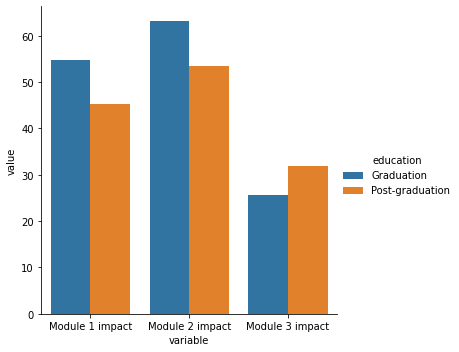

In [15]:
ed_wise_impact = round(100*score_temp[[f'Module {i} impact' for i in range(1, 4)]].groupby(score_temp['education']).mean()/
      (100-score_temp[[f'Module {i} PreTest' for i in range(1, 4)]].groupby(score_temp['education']).mean().values), 2)

print(ed_wise_impact.T)
ed_wise_impact['education'] = ed_wise_impact.index
sns.catplot(data=pd.melt(ed_wise_impact, id_vars='education'), kind='bar', x='variable', y='value', hue='education')
plt.show()

As expected, the above plot of realised potential impact show same trends as observed earlier.<br>
But the difference here is much less and all the average impacts lie in the respective confidence intervals calculated earlier which means we don't  have enough evidence to conclude i.e., **the difference we see between Graduation vs Post-graduation could also have arisen by chance.**

In [16]:
score_temp = score.dropna(subset=['education'])
score_temp = score_temp[~score_temp['education'].isin(['Graduation', 'Post-graduation'])].dropna(subset=score_temp.columns.drop(['age', 'education']), how='all')
score_temp

,age,education,Module 1 PreTest,Module 1 PostTest,Module 2 PreTest,Module 2 PostTest,Module 3 PreTest,Module 3 PostTest,Module 1 impact,Module 2 impact,Module 3 impact
Student ID,,,,,,,,,,,
NH0000001,12.0,secondary (10th grade),63.0,38.0,NaN,NaN,NaN,NaN,-25.0,NaN,NaN
NH0000026,56.0,No education,69.0,76.0,65.0,71.0,38.0,63.0,7.0,6.0,25.0
NH0000051,25.0,PUC/12th grade completed,31.0,53.0,53.0,82.0,38.0,69.0,22.0,29.0,31.0
NH0000067,30.0,secondary (10th grade),88.0,100.0,88.0,65.0,25.0,38.0,12.0,-23.0,13.0
NH0000093,35.0,PUC/12th grade completed,94.0,100.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN


These are the students we left out during educational background wise analysis.<br>
2nd and 3rd row show significant impact of training because of very low PreTest score possibly due to less or no education.<br>
Rest of the rows don't seem to show any specific patterns.

## Final Summary

### Overall impact
1. Overall impact of the modules is positive and significant as shown by hypothesis testing.
2. In all the modules, average post test score didn't improve above a certain point (~90).
3. Module 3 has lower PreTest and PostTest scores compared to others. This hints that difficulty level of this module is higher.

### Age-wise impact
1. Average impact of module 2 on age group 32-45 is lower and on age group 45+ is higher but post test scores are similar.
2. Average impact of module 3 on age group 45+ is lower but sample size is also very small for this set (5) and therefore this may not be reliable.

### Educational background-wise impact
1. Module 1 and 2 have slightly more impact on students with graduation as compared to those with post-graduation.
2. Module 3 has slightly more impact on students with post-graduation as compared to those with graduation.

    However we don't have enough evidence to conclude educational background wise difference i.e., the difference we see between Graduation vs Post-graduation could also have arisen by chance.
    
## Additional data / context

1. The questions can be classified in two categories: ones which are directly answered in the module and others which aren't. Students are more likely to improve on first category of questions than second. So by looking at number of questions in second category, we might be able to explain why post test score average didn't improve beyond a certain point (~90) in all age groups.
2. If we can get more students for certain subsets (like 45+ age group), it might give us more reliable statistics and trends.